In [1]:
from chain_model.extraction_day_chain import day_chain
from chain_model.extraction_loacation_chain import location_chain
from chain_model.extraction_schedule_or_place_chain import sch_or_place_chain
from chain_model.place_search_chain import place_search_chain
from chain_model.schedule_chain import schedule_chain
from chain_model.discrimination_language import discrimination_language
from chain_model.translation_question import translation_question
from chain_model.error_handle_chain import error_handle_chain
from chain_model.is_schedule_error import schedule_error_chain
from chain_model.schedule_change_chain import schedule_change_chain

from dotenv import load_dotenv
load_dotenv()


from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import messages_to_history
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
import ast
import os
import random

import json
import pickle
import faiss
import numpy as np
from typing import List

from langchain.schema import Document, BaseRetriever
from langchain.embeddings.openai import OpenAIEmbeddings
from konlpy.tag import Okt
from rank_bm25 import BM25Okapi

from pydantic import PrivateAttr


def load_documents(filepath: str) -> List[dict]:
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

def load_bm25(filepath: str) -> BM25Okapi:
    with open(filepath, "rb") as f:
        bm25 = pickle.load(f)
    return bm25

def load_faiss_index(filepath: str) -> faiss.Index:
    faiss_index = faiss.read_index(filepath)
    return faiss_index

def load_faiss_metadata(filepath: str) -> List[dict]:
    with open(filepath, "rb") as f:
        metadata_list = pickle.load(f)
    return metadata_list


documents_gangnam = load_documents("faiss_bm25/gangnam/documents_gangnam.json")
documents_jongro = load_documents("faiss_bm25/jongro/documents_jongro.json")
documents_yongsan = load_documents("faiss_bm25/yongsan/documents_yongsan.json")
documents_junggu = load_documents("faiss_bm25/junggu/documents_Junggu.json")

bm25_gangnam = load_bm25("faiss_bm25/gangnam/bm25_gangnam.pkl")
bm25_jongro = load_bm25("faiss_bm25/jongro/bm25_jongro.pkl")
bm25_yongsan = load_bm25("faiss_bm25/yongsan/bm25_yongsan.pkl")
bm25_junggu = load_bm25("faiss_bm25/junggu/bm25_Junggu.pkl")

faiss_index_gangnam = load_faiss_index("faiss_bm25/gangnam/faiss_gangnam.index")
faiss_index_jongro = load_faiss_index("faiss_bm25/jongro/faiss_jongro.index")
faiss_index_yongsan = load_faiss_index("faiss_bm25/yongsan/faiss_yongsan.index")
faiss_index_junggu = load_faiss_index("faiss_bm25/junggu/faiss_Junggu.index")

metadata_list_gangnam = load_faiss_metadata("faiss_bm25/gangnam/faiss_metadata_gangnam.pkl")
metadata_list_jongro = load_faiss_metadata("faiss_bm25/jongro/faiss_metadata_jongro.pkl")
metadata_list_yongsan = load_faiss_metadata("faiss_bm25/yongsan/faiss_metadata_yongsan.pkl")
metadata_list_junggu = load_faiss_metadata("faiss_bm25/junggu/faiss_metadata_Junggu.pkl")

class HybridBM25FaissRetriever(BaseRetriever):
    # Pydantic이 인식하지 않는 속성은 PrivateAttr로 선언 (언더스코어 사용)
    _bm25: BM25Okapi = PrivateAttr()
    _faiss_index: faiss.Index = PrivateAttr()
    _documents: List[dict] = PrivateAttr()
    _metadata_list: List[dict] = PrivateAttr()
    _embeddings: OpenAIEmbeddings = PrivateAttr()
    _okt: Okt = PrivateAttr()

    # 초기화 메서드에서 PrivateAttr에 값 할당
    def __init__(
        self, 
        bm25: BM25Okapi, 
        faiss_index: faiss.Index, 
        documents: List[dict], 
        metadata_list: List[dict], 
        # openai_api_key: str, 
        top_k: int = 5
    ):
        super().__init__()
        self._bm25 = bm25
        self._faiss_index = faiss_index
        self._documents = documents
        self._metadata_list = metadata_list
        self._top_k = top_k
        self._embeddings = OpenAIEmbeddings(
            model="text-embedding-ada-002",
            # openai_api_key=openai_api_key
        )
        self._okt = Okt()

    def get_openai_embedding(self, text: str) -> np.ndarray:
        """
        LangChain의 OpenAIEmbeddings를 사용하여 텍스트의 임베딩을 얻습니다.
        """
        vector = self._embeddings.embed_query(text)  # List[float]
        return np.array(vector, dtype=np.float32)

    def tokenize_korean(self, text: str) -> List[str]:
        """
        Okt를 사용하여 한국어 텍스트를 토큰화합니다.
        """
        return self._okt.morphs(text)

    def _bm25_search(self, query: str) -> List[int]:
        """
        BM25를 사용하여 상위 top_k 문서 인덱스를 반환합니다.
        """
        tokenized_query = self.tokenize_korean(query)
        scores = self._bm25.get_scores(tokenized_query)
        ranked = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)
        top_docs = [r[0] for r in ranked[:self._top_k]]
        return top_docs

    def _faiss_search(self, query_emb: np.ndarray) -> List[int]:
        """
        Faiss를 사용하여 상위 top_k 문서 인덱스를 반환합니다.
        """
        distances, indices = self._faiss_index.search(query_emb, self._top_k)
        return list(indices[0])

    def get_relevant_documents(self, query: str) -> List[Document]:
        """
        BM25와 Faiss를 사용하여 관련 문서를 검색하고, LangChain의 Document 객체로 반환합니다.
        """
        # BM25 검색
        bm25_indices = self._bm25_search(query)

        # Faiss 검색
        query_emb = self.get_openai_embedding(query).reshape(1, -1)
        faiss_indices = self._faiss_search(query_emb)

        # 결과 통합 (합집합)
        combined_indices = list(set(bm25_indices + faiss_indices))

        # Document 객체 생성
        docs = []
        for idx in combined_indices:
            content = self._documents[idx]["page_content"]
            meta = self._documents[idx]["metadata"]
            doc = Document(page_content=content, metadata=meta)
            docs.append(doc)

        return docs

    async def aget_relevant_documents(self, query: str) -> List[Document]:
        """
        비동기 방식으로 관련 문서를 검색합니다.
        """
        return self.get_relevant_documents(query)

retriever_naver_gangnam = HybridBM25FaissRetriever(
    bm25=bm25_gangnam,
    faiss_index=faiss_index_gangnam,
    documents=documents_gangnam,
    metadata_list=metadata_list_gangnam,
    top_k=25
)

retriever_naver_jongro = HybridBM25FaissRetriever(
    bm25=bm25_jongro,
    faiss_index=faiss_index_jongro,
    documents=documents_jongro,
    metadata_list=metadata_list_jongro,
    top_k=25
)

retriever_naver_yongsan = HybridBM25FaissRetriever(
    bm25=bm25_yongsan,
    faiss_index=faiss_index_yongsan,
    documents=documents_yongsan,
    metadata_list=metadata_list_yongsan,
    top_k=25
)

retriever_naver_Junggu = HybridBM25FaissRetriever(
    bm25=bm25_junggu,
    faiss_index=faiss_index_junggu,
    documents=documents_junggu,
    metadata_list=metadata_list_junggu,
    top_k=25
)

embeddings = OpenAIEmbeddings()

# BASE_DIR은 현재 파일이 위치한 디렉토리를 기준으로 설정
BASE_DIR = os.getcwd()

# FAISS 인덱스 파일 경로를 리스트에 추가
faiss_index_paths = []
# faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "naver_map_gangnam_faiss"))
# faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "naver_map_jongro_faiss"))
# faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "naver_map_Junggu_faiss"))
# faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "naver_map_yongsan_faiss"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "opendata_gangnam_all"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "opendata_jongro_all"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "opendata_junggu_all"))
faiss_index_paths.append(os.path.join(BASE_DIR, "Faiss", "opendata_yongsan_all"))

# FAISS 인덱스를 로드하고 리트리버를 생성
retrieves = []
for path in faiss_index_paths:
    retrieves.append(FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True).as_retriever())

# 각 리트리버를 변수에 할당
# retriever_naver_gangnam = retrieves[0]
# retriever_naver_jongro = retrieves[1]
# retriever_naver_Junggu = retrieves[2]
# retriever_naver_yongsan = retrieves[3]
retriever_opendata_gangnam = retrieves[0]
retriever_opendata_jongro = retrieves[1]
retriever_opendata_junggu = retrieves[2]
retriever_opendata_yongsan = retrieves[3]

# 리트리버의 검색 매개변수를 설정 (검색 결과의 개수)
# retriever_naver_gangnam.search_kwargs = {"k": 50}
# retriever_naver_jongro.search_kwargs = {"k": 50}
# retriever_naver_Junggu.search_kwargs = {"k": 50}
# retriever_naver_yongsan.search_kwargs = {"k": 50}
retriever_opendata_gangnam.search_kwargs = {"k": 50}
retriever_opendata_jongro.search_kwargs = {"k": 50}
retriever_opendata_junggu.search_kwargs = {"k": 50}
retriever_opendata_yongsan.search_kwargs = {"k": 50}

# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[List[str], add_messages]  # 질문(누적되는 list)
    context_naver_gangnam: Annotated[List, "context_naver_gangnam"]  # 문서의 검색 결과
    context_naver_jongro: Annotated[List, "context_naver_jongro"]  # 문서의 검색 결과
    context_naver_Junggu: Annotated[List, "context_naver_Junggu"]  # 문서의 검색 결과
    context_naver_yongsan: Annotated[List, "context_naver_yongsan"]  # 문서의 검색 결과
    context_opendata_gangnam: Annotated[List, "context_opendata_gangnam"]  # 문서의 검색 결과
    context_opendata_jongro: Annotated[List, "context_opendata_jongro"]  # 문서의 검색 결과
    context_opendata_Junggu: Annotated[List, "context_opendata_Junggu"]  # 문서의 검색 결과
    context_opendata_yongsan: Annotated[List, "context_opendata_yongsan"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    DB_chat_history: Annotated[str, "DB_chat_history"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    webOrRetriever: Annotated[str, "webOrRetriever"]  # 웹 or 리트리버 검색
    ScheduleOrplace: Annotated[str, "ScheduleOrplace"]  # 일정 or 장소
    location: Annotated[str, "location"]  # 지역 리스트
    dayCheck: Annotated[str, "dayCheck"]  # 몇일 여행?
    languageCheck: Annotated[str, "languageCheck"]  # 언어판별
    translated_question: Annotated[str, "translated_question"]  # 번역된 질문
    location_error: Annotated[int, "location_error"]  # 장소 에러
    day_error: Annotated[int, "day_error"]  # 여행 일 수 에러
    language_error: Annotated[int, "language_error"]  # 언어 에러
    error_or_normal: Annotated[str, "error_or_normal"]  # 스케줄 에러
    


####-----노드 함수--------#####

def initialize_error_status(state):
    return{
            "language_error": 0,
            "location_error": 0,
            "day_error": 0,
                }

def language_check_is_normal(state):
    pass

def day_locatoin_check(state):

    pass

def translate_question(state: GraphState) -> GraphState:
    chain_translation_question = translation_question()
    response = chain_translation_question.invoke(
        {
            "question": state["question"][-1].content
        }
    )

    return {"translated_question": response}

def language_check(state: GraphState) -> GraphState:
    chain_discrimination_language = discrimination_language()
    response = chain_discrimination_language.invoke(
        {"question": state["question"][-1].content}
    )

    return {"languageCheck": response}

def Schedule_day_check(state: GraphState) -> GraphState:
    chain_day = day_chain()
    response = chain_day.invoke(
        {"question": state["question"][-1].content}
    )

    try :
        ast.literal_eval(response)
    except :
        return {"day_error" : 1}

    return {"dayCheck": response}

# 장소검색 or 일정 검색
def Schedule_or_place_check(state: GraphState) -> GraphState:
    # 관련성 체크를 실행("yes" or "no")
    chain_sch_or_placeSearch = sch_or_place_chain()
    response = chain_sch_or_placeSearch.invoke(
        {"question": state["question"][-1].content}
    )

    return {"ScheduleOrplace": response}


# 일정 장소검색 리트리버 분기 체크하는 함수(router)
def is_place(state: GraphState) -> GraphState:
    if state["ScheduleOrplace"] == "일정":
        return "일정"
    elif state["ScheduleOrplace"] == "일정변경":
        return "일정변경"
    else:
        return "장소검색"
    

def error_check(state: GraphState) -> GraphState:
    
    error_or_normal_chain = schedule_error_chain()
    response = error_or_normal_chain.invoke(
        {
            "state_location": state["location_error"],
            "state_day": state["day_error"]
        }
    )

    return {"error_or_normal": response}


#  분기 체크하는 함수(router)
def is_error(state: GraphState) -> GraphState:
    if state["error_or_normal"] == "에러":
        return "에러"
    else:
        return "정상"
    
def is_language_error(state: GraphState) -> GraphState:
    if state["languageCheck"] == "언어정보없음":
        return "에러"
    else:
        return "정상"

def language_error_node(state):
    return{"language_error": 1}

# 지역 판별
def location_check(state: GraphState) -> GraphState:

    chain_location = location_chain()

    response = chain_location.invoke(
        {"question": state["question"][-1].content}
    )
    try :
        location_list = ast.literal_eval(response)
    except :
        return {"location_error" : 1}
    
    if len(location_list) == 0:
        return {"location_error" : 1}
    
    return {"location": response}

def error_handling(state: GraphState) -> GraphState:
    state_location = state["location_error"]
    state_day = state["day_error"]
    state_language = state["language_error"]
    language = state['languageCheck']
    latest_question = state["question"][-1].content


    error_handler_chain = error_handle_chain()
    response = error_handler_chain.invoke(
        {
            "state_location": state_location,
            "state_day": state_day,
            "state_language": state_language,
            "language" : language,
            "question" : latest_question

        }
    )

    return {"translated_question": response}

    
# 문서 검색 노드--------------------------------------------------------------------------------------------------------------------------
def retrieve_document_naver(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["translated_question"]
    
    retrieved_docs_yongsan = []
    retrieved_docs_jongro = []
    retrieved_docs_gangman = []
    retrieved_docs_junggu = []

    retrieved_docs_yongsan = retriever_naver_yongsan.invoke(latest_question)
    retrieved_docs_jongro = retriever_naver_jongro.invoke(latest_question)
    retrieved_docs_gangman = retriever_naver_gangnam.invoke(latest_question)
    retrieved_docs_junggu = retriever_naver_Junggu.invoke(latest_question)

    return {"context_naver_gangnam": retrieved_docs_gangman,
            "context_naver_jongro": retrieved_docs_jongro,
            "context_naver_Junggu": retrieved_docs_junggu,
            "context_naver_yongsan": retrieved_docs_yongsan}

#------------------------------------------------------------------------------------------------------------------------------------------------


def retrieve_document_opendata(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["translated_question"]

    retrieved_docs_yongsan = []
    retrieved_docs_jongro = []
    retrieved_docs_gangman = []
    retrieved_docs_junggu = []

    retrieved_docs_yongsan = retriever_opendata_yongsan.invoke(latest_question)
    retrieved_docs_jongro = retriever_opendata_jongro.invoke(latest_question)
    retrieved_docs_gangman = retriever_opendata_gangnam.invoke(latest_question)
    retrieved_docs_junggu = retriever_opendata_junggu.invoke(latest_question)

    return {
        "context_opendata_gangnam": retrieved_docs_gangman,
        "context_opendata_jongro": retrieved_docs_jongro,
        "context_opendata_Junggu": retrieved_docs_junggu,
        "context_opendata_yongsan": retrieved_docs_yongsan,
            }


# 일정 생성 노드----------------------------------------------------------------------------

def llm_Schedule_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content
    location_str = state['location']
    day_str = state['dayCheck']
    language = state['languageCheck']

    location = ast.literal_eval(location_str)

    if len(location) == 1:
        num_retriever_search = 10
    elif len(location) == 2:
        num_retriever_search = 7
    elif len(location) == 3:
        num_retriever_search = 5
    elif len(location) == 4:
        num_retriever_search = 4
    
    try : day = ast.literal_eval(day_str)
    except : return {'day_error' : 1}

    if language == '언어정보없음':
        return {'language_error' :1}
    
    response_list = []
    place_list = []
    place_yongsan =[]
    place_jongro =[]
    place_gangman =[]
    place_junggu =[]
    additional_list=[]
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    yongsan = '용산구'
    jongro = '종로구'
    gangman = '강남구'
    junggu = '중구'
# ['장소이름 : ' + test.metadata.get('store_name') + ', 영문이름 : ' + test.metadata.get('store_name_english') + ' 영문주소 : ' + test.metadata.get('address_english')  for test in test_list]
# ['장소이름 : ' + test.metadata.get('store_name') + ', 일본어이름 : ' + test.metadata.get('store_name_japanese') + ' 일본어주소 : ' + test.metadata.get('address_japanese')  for test in test_list]
# ['장소이름 : ' + test.metadata.get('store_name') + ', 중국어이름 : ' + test.metadata.get('store_name_chinese') + ' 중국어주소 : ' + test.metadata.get('address_chinese')  for test in test_list]
    for i in range(1, day+1):
        if yongsan in location:
            place_yongsan = state["context_naver_yongsan"]
            selected = random.sample(place_yongsan, num_retriever_search)
            if language == '영어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 영문이름 : ' + i.metadata.get('store_name_english') + ', 영문주소 : ' + i.metadata.get('address_english') for i in selected]) 
            elif language == '한국어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 영문이름 : ' + i.metadata.get('store_name_english') + ', 영문주소 : ' + i.metadata.get('address_english') for i in selected]) 
            elif language == '일본어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 일본어이름 : ' + i.metadata.get('store_name_japanese') + ', 일본어주소 : ' + i.metadata.get('address_japanese') for i in selected]) 
            elif language == '중국어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 중국어이름 : ' + i.metadata.get('store_name_chinese') + ', 중국어주소 : ' + i.metadata.get('address_chinese') for i in selected]) 
            place_list.extend(selected)
            place_list.extend(random.sample(state["context_opendata_yongsan"], num_retriever_search))

        if jongro in location:
            place_jongro = state["context_naver_jongro"]
            selected = random.sample(place_jongro, num_retriever_search)
            if language == '영어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 영문이름 : ' + i.metadata.get('store_name_english') + ', 영문주소 : ' + i.metadata.get('address_english') for i in selected]) 
            elif language == '한국어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 영문이름 : ' + i.metadata.get('store_name_english') + ', 영문주소 : ' + i.metadata.get('address_english') for i in selected]) 
            elif language == '일본어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 일본어이름 : ' + i.metadata.get('store_name_japanese') + ', 일본어주소 : ' + i.metadata.get('address_japanese') for i in selected]) 
            elif language == '중국어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 중국어이름 : ' + i.metadata.get('store_name_chinese') + ', 중국어주소 : ' + i.metadata.get('address_chinese') for i in selected]) 
            place_list.extend(selected)
            place_list.extend(random.sample(state["context_opendata_jongro"], num_retriever_search))

        if gangman in location:
            place_gangman = state["context_naver_gangnam"]
            selected = random.sample(place_gangman, num_retriever_search)
            if language == '영어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 영문이름 : ' + i.metadata.get('store_name_english') + ', 영문주소 : ' + i.metadata.get('address_english') for i in selected]) 
            elif language == '한국어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 영문이름 : ' + i.metadata.get('store_name_english') + ', 영문주소 : ' + i.metadata.get('address_english') for i in selected]) 
            elif language == '일본어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 일본어이름 : ' + i.metadata.get('store_name_japanese') + ', 일본어주소 : ' + i.metadata.get('address_japanese') for i in selected]) 
            elif language == '중국어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 중국어이름 : ' + i.metadata.get('store_name_chinese') + ', 중국어주소 : ' + i.metadata.get('address_chinese') for i in selected]) 
            place_list.extend(selected)
            place_list.extend(random.sample(state["context_opendata_gangnam"], num_retriever_search))

        if junggu in location:
            place_junggu = state["context_naver_Junggu"]
            selected = random.sample(place_junggu, num_retriever_search)
            if language == '영어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 영문이름 : ' + i.metadata.get('store_name_english') + ', 영문주소 : ' + i.metadata.get('address_english') for i in selected]) 
            elif language == '한국어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 영문이름 : ' + i.metadata.get('store_name_english') + ', 영문주소 : ' + i.metadata.get('address_english') for i in selected]) 
            elif language == '일본어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 일본어이름 : ' + i.metadata.get('store_name_japanese') + ', 일본어주소 : ' + i.metadata.get('address_japanese') for i in selected]) 
            elif language == '중국어':
                additional_list.extend(['장소이름 : ' + i.metadata.get('store_name') + ', 좌표 : ' + i.metadata.get('coordinates') + ', 중국어이름 : ' + i.metadata.get('store_name_chinese') + ', 중국어주소 : ' + i.metadata.get('address_chinese') for i in selected]) 
            place_list.extend(selected)
            place_list.extend(random.sample(state["context_opendata_Junggu"], num_retriever_search))

        #검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
        place_list_text = "\n".join(
        [
            f"<content>{doc.page_content}</content>"
            for doc in place_list
        ]
        )

        additional_text = "\n".join(
        [
            f"<additional>{doc}</additional>"
            for doc in additional_list
        ]
        )

        chain = schedule_chain()
        # 체인을 호출하여 답변을 생성합니다.
        response = chain.invoke(
            {
                "question": latest_question,
                "context": place_list_text,
                "chat_history": messages_to_history(state["messages"]),
                "day" : i,
                "language" : language,
                "additional" : additional_text
            }
        )
        place_list.clear()
        response_list.append(response)
        print('\n')

    response_list_text = "\n".join(
    [
        f"{doc}"
        for doc in response_list
    ]
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    # print(state["messages"])
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response_list_text)],
    }
# 일정 생성 노드 끝----------------------------------------------------------------------------

# 일정 변경 노드-------------------------------------------------------------------------------

def llm_Schedule_change_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content
    location_str = state['location']
    language = state['languageCheck']

    location = ast.literal_eval(location_str)

    if len(location) == 1:
        num_retriever_search = 10
    elif len(location) == 2:
        num_retriever_search = 7
    elif len(location) == 3:
        num_retriever_search = 5
    elif len(location) == 4:
        num_retriever_search = 4

    if language == '언어정보없음':
        return {'language_error' :1}

    place_list = []
    place_yongsan =[]
    place_jongro =[]
    place_gangman =[]
    place_junggu =[]
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    yongsan = '용산구'
    jongro = '종로구'
    gangman = '강남구'
    junggu = '중구'


    if yongsan in location:
        place_yongsan = state["context_naver_yongsan"]

        place_list.extend(place_yongsan[:num_retriever_search])
        place_list.extend(state["context_opendata_yongsan"][:num_retriever_search])

    if jongro in location:
        place_jongro = state["context_naver_jongro"]

        place_list.extend(place_jongro[:num_retriever_search])
        place_list.extend(state["context_opendata_jongro"][:num_retriever_search])

    if gangman in location:
        place_gangman = state["context_naver_gangnam"]
        place_list.extend(place_gangman[:num_retriever_search])
        place_list.extend(state["context_opendata_gangnam"][:num_retriever_search])


    if junggu in location:
        place_junggu = state["context_naver_Junggu"]

        place_list.extend(place_junggu[:num_retriever_search])
        place_list.extend(state["context_opendata_Junggu"][:num_retriever_search])


    #검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    place_list_text = "\n".join(
    [
        f"<content>{doc.page_content}</content>"
        for doc in place_list
    ]
    )

    change_chain = schedule_change_chain()
    # 체인을 호출하여 답변을 생성합니다.
    response = change_chain.invoke(
        {
            "question": latest_question,
            "context": place_list_text,
            "chat_history": messages_to_history(state["messages"]),
            "language" : language
        }
    )


    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    # print(state["messages"])
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

# 장소 검색 노드 ----------------------------------------------------------------------------

def llm_place_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    language = state['languageCheck']

    place_list = []
    place_yongsan =[]
    place_jongro =[]
    place_gangman =[]
    place_junggu =[]


    place_yongsan = state["context_naver_yongsan"]
    place_yongsan = place_yongsan[:4]
    place_list.extend(place_yongsan)

    place_jongro = state["context_naver_jongro"]
    place_jongro = place_jongro[:4]
    place_list.extend(place_jongro)


    place_gangman = state["context_naver_gangnam"]
    place_gangman = place_gangman[:4]
    place_list.extend(place_gangman)


    place_junggu = state["context_naver_Junggu"]
    place_junggu = place_junggu[:4]
    place_list.extend(place_junggu)

    place_opendata_junggu = state["context_opendata_yongsan"]
    place_opendata_junggu = place_opendata_junggu[:3]
    place_list.extend(place_opendata_junggu)

    place_junggu = state["context_opendata_jongro"]
    place_opendata_junggu = place_opendata_junggu[:3]
    place_list.extend(place_opendata_junggu)

    place_opendata_junggu = state["context_opendata_gangnam"]
    place_opendata_junggu = place_opendata_junggu[:3]
    place_list.extend(place_opendata_junggu)

    place_opendata_junggu = state["context_naver_Junggu"]
    place_opendata_junggu = place_opendata_junggu[:3]
    place_list.extend(place_opendata_junggu)

    place_list_text = "\n".join(
    [
        f"<content>{doc.page_content}</content>"
        for doc in place_list
    ]
    )

    # 체인을 호출하여 답변을 생성합니다.
    chain_place_search = place_search_chain()
    response = chain_place_search.invoke(
        {
            "question": latest_question,
            "context": place_list_text,
            "chat_history": messages_to_history(state["messages"]),
            "language" : language
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    # print(state["messages"])
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

# 장소 검색 노드  끝----------------------------------------------------------------------------



# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("location_check", location_check)
workflow.add_node("Schedule_day_check", Schedule_day_check)
workflow.add_node("retrieve_document_naver", retrieve_document_naver)
workflow.add_node("retrieve_opendata", retrieve_document_opendata)
workflow.add_node("llm_Schedule_answer", llm_Schedule_answer)
workflow.add_node("Schedule_or_place_check", Schedule_or_place_check)
workflow.add_node("llm_place_answer", llm_place_answer)
workflow.add_node("language_check", language_check)
workflow.add_node("translate_question", translate_question)
workflow.add_node("error_handling", error_handling)
workflow.add_node("language_check_is_normal", language_check_is_normal)
workflow.add_node("day_locatoin_check", day_locatoin_check)
workflow.add_node("error_check", error_check)
workflow.add_node("initialize_error_status", initialize_error_status)
workflow.add_node("language_error_node", language_error_node)
workflow.add_node("llm_Schedule_change_answer", llm_Schedule_change_answer)



workflow.set_entry_point("initialize_error_status")
workflow.add_edge("initialize_error_status", "translate_question") 

workflow.add_edge("translate_question", "language_check") 

workflow.add_conditional_edges(
    "language_check",  
    is_language_error,
    {
        "정상": "language_check_is_normal",  #일정
        "에러": "language_error_node",  # 장소검색
    },
)
workflow.add_edge("language_error_node", "error_handling") 


workflow.add_edge("language_check_is_normal", "retrieve_document_naver") 
workflow.add_edge("language_check_is_normal", "retrieve_opendata") 
workflow.add_edge("retrieve_document_naver", "Schedule_or_place_check") 
workflow.add_edge("retrieve_opendata", "Schedule_or_place_check") 

workflow.add_conditional_edges(
    "Schedule_or_place_check",  
    is_place,
    {
        "일정": "day_locatoin_check",  #일정
        "장소검색": "llm_place_answer", # 장소검색
        "일정변경" : "llm_Schedule_change_answer" 
    },
)

workflow.add_edge("day_locatoin_check", "location_check") 
workflow.add_edge("day_locatoin_check", "Schedule_day_check") 

workflow.add_edge("location_check", "error_check") 
workflow.add_edge("Schedule_day_check", "error_check") 

workflow.add_conditional_edges(
    "error_check",  
    is_error,
    {
        "에러": "error_handling",  #일정
        "정상": "llm_Schedule_answer",  # 장소검색
    },
)


# workflow.add_edge("llm_Schedule_answer", "initialize_error_status")  # 답변 -> 종료
# workflow.add_edge("llm_place_answer", "initialize_error_status")  # 답변 -> 종료
# workflow.add_edge("error_handling", "initialize_error_status")  # 답변 -> 종료
workflow.add_edge("llm_Schedule_answer", END)  # 답변 -> 종료
workflow.add_edge("llm_place_answer", END)  # 답변 -> 종료
workflow.add_edge("error_handling", END)  # 답변 -> 종료
workflow.add_edge("llm_Schedule_change_answer", END)  # 답변 -> 종료

# 체크포인터 설정
memory = MemorySaver()


/var/folders/_v/g1qmsq595kq_fg_zv8n2022h0000gn/T/ipykernel_5033/1740893107.py:82: DeprecationWarning: Retrievers must implement abstract `_get_relevant_documents` method instead of `get_relevant_documents`
  class HybridBM25FaissRetriever(BaseRetriever):
/var/folders/_v/g1qmsq595kq_fg_zv8n2022h0000gn/T/ipykernel_5033/1740893107.py:82: DeprecationWarning: Retrievers must implement abstract `_aget_relevant_documents` method instead of `aget_relevant_documents`
  class HybridBM25FaissRetriever(BaseRetriever):
/var/folders/_v/g1qmsq595kq_fg_zv8n2022h0000gn/T/ipykernel_5033/1740893107.py:107: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  self._embeddings = OpenAIEmbeddings(


In [2]:
# 컴파일
app = workflow.compile(checkpointer=memory)


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

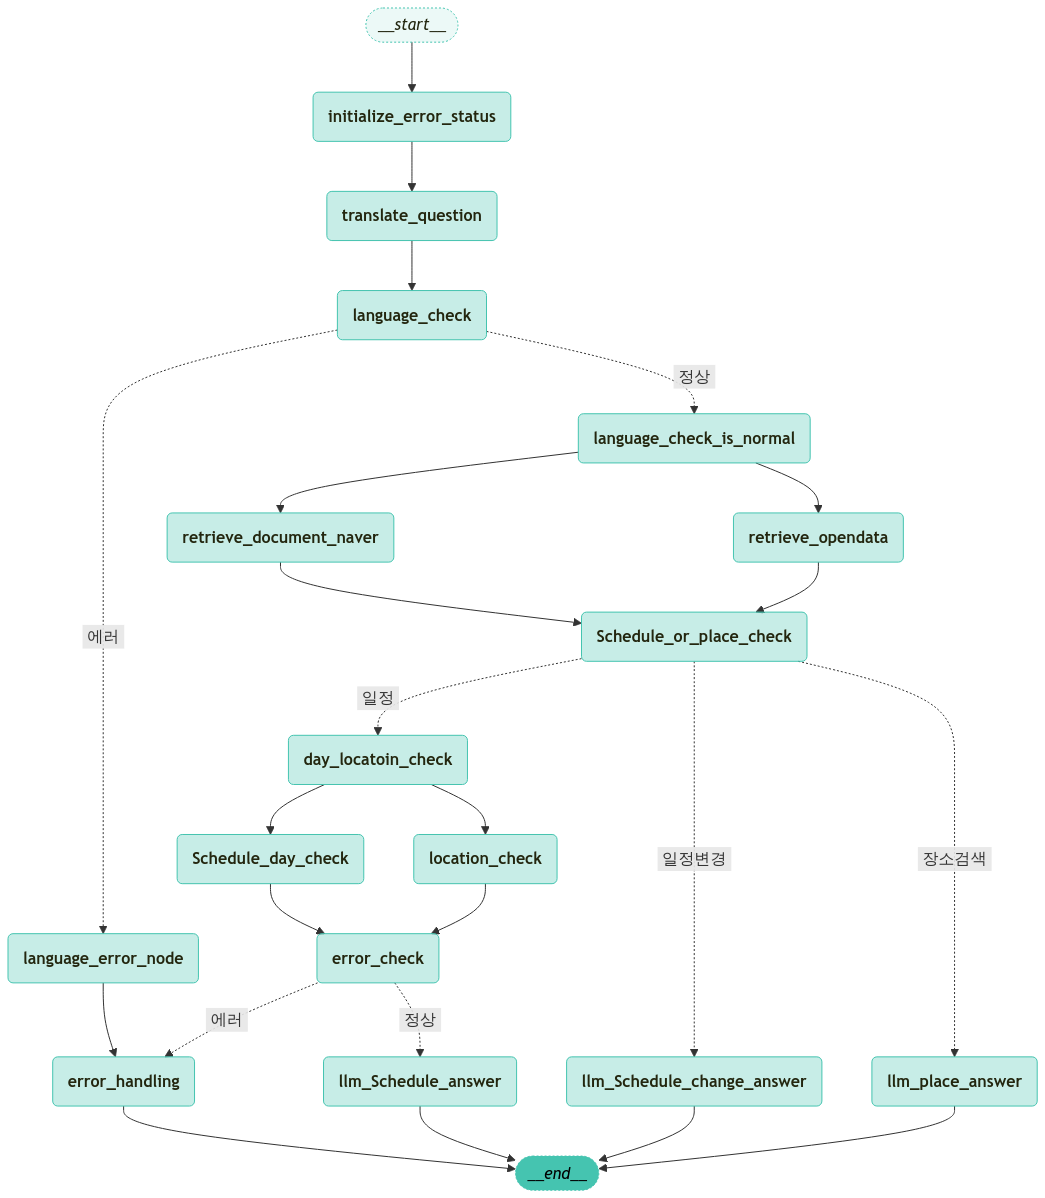

In [5]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [14]:
question = 'Tell me your schedule for 2 nights and 3 days in Seoul'

In [11]:
question = '1일차 점심은 중식당으로 바꿔줘'

In [3]:
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

In [4]:
inputs = GraphState(question=question)

In [15]:
# 질문 입력
inputs = GraphState(question=question)

ans=app.stream(input=inputs, config=config, stream_mode='messages')

In [13]:
print(ans)

<generator object Pregel.stream at 0x301b111b0>


In [16]:
for chunk, meta in ans:

    if meta.get('langgraph_node') == 'llm_Schedule_answer':

        print(chunk.content, end='')

    if meta.get('langgraph_node') == 'llm_place_answer':

        print(chunk.content, end='')

    if meta.get('langgraph_node') == 'llm_Schedule_change_answer':

        print(chunk.content, end='')

    if meta.get('langgraph_node') == 'error_handling':

        print(chunk.content, end='')

- **Day 1**:

- **Breakfast**
  - **Breakfast Place**: 여기래 (Here it is)
    - **Address**: 서울 용산구 후암로23길 3-7 (3-7, Huam-ro 23-gil, Yongsan-gu, Seoul)
    - **Business Hours**: Mon-Fri 11:00 - 20:30, Sat 11:00 - 15:00, Sun Closed
    - **Restaurant Features**: Offers a variety of Korean dishes with good value and fresh ingredients.

- **Lunch**
  - **Lunch Place**: 박사네등심 (Doctor's sirloin)
    - **Address**: 서울 용산구 원효로90길 16 1층 (16, Wonhyo-ro 90-gil, Yongsan-gu, Seoul)
    - **Business Hours**: Mon-Fri 11:30 - 21:45, Sat 17:00 - 21:45
    - **Restaurant Features**: Serves high-quality aged beef with a variety of meat dishes at reasonable prices.

  - **Attraction**: 성수미술관 용산점 (Seongsu Art Museum Yongsan Branch)
    - **Address**: 서울 용산구 한강대로62길 55 5층 (5th floor, 55 Hangang-daero 62-gil, Yongsan-gu, Seoul)
    - **Business Hours**: Daily 12:00 - 21:30
    - **Attraction Features**: A contemporary art museum with various exhibitions and experience programs.

- **Dinner**
  - **Dinner Plac

In [36]:
for chunk, meta in ans:

    if meta.get('langgraph_node') == 'llm_Schedule_answer':

        print(chunk.content, end='')


    if meta.get('langgraph_node') == 'llm_place_answer':

        print(chunk.content, end='')

    if meta.get('langgraph_node') == 'llm_Schedule_change_answer':

        print(chunk.content, end='')

    if meta.get('langgraph_node') == 'error_handling':

        print(chunk.content, end='')

- **1일차**:

- **아침**
  - **아침 식사 장소**: 경춘자의라면땡기는날
    - **주소**: 서울 종로구 율곡로3길 82 (82 Yulgok-ro 3-gil, Jongno-gu, Seoul)
    - **영업 시간**: 정보 없음
    - **음식점 특징**: 뚝배기에 조리된 다양한 라면을 제공하며, 면발이 부드럽고 쫄깃합니다. 마지막 면발까지 뜨거운 국물을 즐길 수 있습니다.
    - **기타 정보**: 혼밥하기 좋은 분위기와 가성비 좋은 메뉴가 특징입니다.

- **점심**
  - **점심 식사 장소**: 일일향 광화문
    - **주소**: 서울 종로구 새문안로3길 15 동원빌딩 별관 2층 (15 Saemunan-ro 3-gil, Jongno-gu, Seoul)
    - **영업 시간**: 수~화 11:20 - 21:30 (브레이크타임 15:00 - 17:00)
    - **음식점 특징**: 신선한 재료로 만든 중화요리를 제공하며, 짜장, 짬뽕, 볶음밥 맛집으로 유명합니다.
    - **기타 정보**: 세종문화회관 근처에 위치해 있어 공연 관람 후 방문하기 좋습니다.

- **저녁**
  - **저녁 식사 장소**: 다대기실비 서대문역
    - **주소**: 서울 서대문구 영천시장길 56 B호 (B, 56 Yeongcheon Market-gil, Seodaemun-gu, Seoul)
    - **영업 시간**: 수~토 17:00 - 24:00, 일요일 정기휴무
    - **음식점 특징**: 신선한 회와 다양한 해산물 요리를 제공하는 실비집으로, 가성비가 뛰어난 메뉴가 많습니다.
    - **기타 정보**: 독특한 분위기에서 회식이나 모임에 적합한 장소입니다.

  - **명소**: 세종문화회관
    - **명소 특징**: 다양한 공연과 전시가 열리는 문화 공간으로, 예술과 문화를 즐길 수 있는 장소입니다.
    - **명소 위치**: 서울 종로구 세종로 81-3 (81-3 Sejong-ro, Jongno-gu,

In [3]:
test_list = []

a=retriever_naver_gangnam.invoke('카페 추천해줘')

test_list.extend(random.sample(a, 5))

In [17]:
test_list[4].metadata

{'store_id': 1850276336,
 'store_name': '카페브릭나인',
 'coordinates': '(127.1166254, 37.4841717)',
 'store_name_english': 'Cafe Brick Nine',
 'address_english': 'Cafe Brick Nine, 1st floor, H Business Park D Building, 26 Beobwon-ro 9-gil, Songpa-gu, Seoul',
 'store_name_japanese': 'カフェブリックナイン',
 'address_japanese': 'ソウル松坡区裁判所路9ギル26 HビジネスパークD洞、1階カフェブリックナイン',
 'store_name_chinese': '砖九咖啡馆',
 'address_chinese': '首尔特别市松坡区法院路9街26号H商务园D栋1楼Cafe Brick Nine'}

In [9]:
test_list[0].metadata.get('store_name_english')

'Hodeng'

In [16]:
['장소이름 : ' + test.metadata.get('store_name') + ', 영문이름 : ' + test.metadata.get('store_name_english') + ' 영문주소 : ' + test.metadata.get('address_english')  for test in test_list]
['장소이름 : ' + test.metadata.get('store_name') + ', 일본어이름 : ' + test.metadata.get('store_name_japanese') + ' 일본어주소 : ' + test.metadata.get('address_japanese')  for test in test_list]
['장소이름 : ' + test.metadata.get('store_name') + ', 중국어이름 : ' + test.metadata.get('store_name_chinese') + ' 중국어주소 : ' + test.metadata.get('address_chinese')  for test in test_list]

['장소이름 : 호뎅, 중국어이름 : 霍登 중국어주소 : 首尔特别市广津区东一路22街35 1楼',
 '장소이름 : 티숨카페, 중국어이름 : 蒂苏姆咖啡馆 중국어주소 : 首尔特别市松坡区石村湖水路 166 号 Tisum Cafe 1楼、2楼',
 '장소이름 : 쿄코코 신논현점, 중국어이름 : 京科科新论岘店 중국어주소 : 首尔市江南区江南大路106街23号地下1层',
 '장소이름 : 영아곱삼, 중국어이름 : 英雅高桑 중국어주소 : 首尔特别市江南区论岘路20街18号Yeongah Gopsam 1楼',
 '장소이름 : 카페브릭나인, 중국어이름 : 砖九咖啡馆 중국어주소 : 首尔特别市松坡区法院路9街26号H商务园D栋1楼Cafe Brick Nine']

In [5]:
c=['카페이름 : ' + test.metadata.get('store_name') + ', 좌표 : ' + test.metadata.get('coordinates') for test in test_list]

In [6]:
'\n'.join(c)

'카페이름 : 호뎅, 좌표 : (127.0663093, 37.5421455)\n카페이름 : 티숨카페, 좌표 : (127.0953734, 37.5066114)\n카페이름 : 쿄코코 신논현점, 좌표 : (127.0274295, 37.5033203)\n카페이름 : 영아곱삼, 좌표 : (127.0463548, 37.478172)\n카페이름 : 카페브릭나인, 좌표 : (127.1166254, 37.4841717)'

In [ ]:
chain = schedule_chain()
# 체인을 호출하여 답변을 생성합니다.
response = chain.invoke(
    {
        "question": latest_question,
        "context": place_list_text,
        "chat_history": messages_to_history(state["messages"]),
        "day" : i,
        "language" : language,
        "coordinates" : coordinates_text
    }
)
place_list.clear()
response_list.append(response)
print('\n')

response_list_text = "\n".join(
[
f"{doc}"
for doc in response_list
]

In [11]:
a=['ㄴㅇㄹㅁㄴㅇㄹㄴㅁㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹ','ㄴㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹ','ㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㄴㅁ']

In [14]:

response_list_text = "\n".join(
[
f"\n{doc}"
for doc in a
])

In [15]:
response_list_text

'\nㄴㅇㄹㅁㄴㅇㄹㄴㅁㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹ\n\nㄴㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹ\n\nㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㅁㄴㅇㄹㄴㅁ'